![](https://camo.githubusercontent.com/518a06d7ca808cd4ad8d5b6deb4ef15983d4649737618153432479f977935bba/68747470733a2f2f7261772e67697468756275736572636f6e74656e742e636f6d2f79616e646578646174617363686f6f6c2f6e6c705f636f757273652f6d61737465722f7265736f75726365732f657870616e64696e675f6d696e645f6c6d5f6b6e5f332e706e67)

reference:

  - [nlp for you](https://lena-voita.github.io/nlp_course/language_modeling.html)

  - [YSDA Natural Language Processing course](https://github.com/yandexdataschool/nlp_course/tree/2023/week03_lm)

# Лабораторная работа №4. Использование нейронных сетей для генерации текста
В ходе работы мы будем обучать нейронные сети генерировать тексты, похожие на стихи поэтов.

## Цель работы
Получить практические навыки решения задачи генерации текста.

## Указания
1. Для работы рекомендуется использовать Google Colab и среду с GPU для ускорения расчетов. Для установки среды, использующей GPU в Google Colab нужно выбрать пункт меню "Среда выполнения" -> "Сменить среду выполнения" -> выбрать аппаратный ускоритель "GPU".

2. Выполнять работу следует последовательно запуская ячейки, анализируя код и приведенные комментарии и разъяснения.

3. В ходе работы будут встречаться вопросы, на которые нужно ответить, создав после него новую ячейку. Вопросы отмечены заголовками 3-го уровня.
Для ответа досточно 1-2 предложений. Но будьте готовы более подробно его пояснить при устной беседе.

4. Обращайте внимание на комментарии `<your choice here>` - здесь вам нужно будет вставить значения параметров либо исходя из анализа кода\выборки (где указано), либо попробовать разные варианты. Парамеры, приведенные тут по умолчанию, не обязательно правильные.

## Варианты заданий

Четные номера по журналу - Пушкин, нечетные - Маяковский.








# Загрузка библиотек

In [1]:
import copy
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt


from random import sample
from IPython.display import clear_output
from torch.utils.data import DataLoader, TensorDataset

При использовании Google Colab следует выбрать среду выполнения с аппаратным ускорителем GPU, что существенно ускорит расчеты. Для установки среды, использующей GPU в Google Colab нужно выбрать пункт меню "Среда выполнения" -> "Сменить среду выполнения" -> выбрать аппаратный ускоритель "GPU". При этом, следующая ячейка, проверяющая доступность CUDA (платформы, использующей графические ускорители), должна возвращать `True`

In [2]:
torch.cuda.is_available()

True

# Загрузим данные

В соответствии с вариантом

In [10]:
!wget -O poems.txt http://uit.mpei.ru/git/main/TDA/raw/branch/master/assets/poems/pushkin.txt

# Маяковский: http://uit.mpei.ru/git/main/TDA/src/branch/master/assets/poems/mayakovskiy.txt


--2024-04-05 17:50:23--  http://uit.mpei.ru/git/main/TDA/raw/branch/master/assets/poems/pushkin.txt
Resolving uit.mpei.ru (uit.mpei.ru)... 193.233.68.149
Connecting to uit.mpei.ru (uit.mpei.ru)|193.233.68.149|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1048627 (1.0M) [text/plain]
Saving to: ‘poems.txt’

poems.txt           100%[===================>]   1.00M   625KB/s    in 1.6s    

2024-04-05 17:50:25 (625 KB/s) - ‘poems.txt’ saved [1048627/1048627]



In [11]:
# Загружаем текст из файла.
# Стихотворения в файле разделены токеном '</s>'

with open("poems.txt") as file:
  data = file.read().split("</s>\n\n")
print(f"Количество стихов: {len(data)}\n", f"Пример стиха:\n\n{data[10]}",  sep="\n")

Количество стихов: 720

Пример стиха:

Возможно ль? вместо роз, Амуром насажденных,
Тюльпанов гордо наклоненных,
Душистых ландышей, ясминов и лилей,
Которых ты всегда любила
И прежде всякой день носила
На мраморной груди твоей —
Возможно ль, милая Климена,
Какая странная во вкусе перемена!..
Ты любишь обонять не утренний цветок,
А вредную траву зелену,
Искусством превращенну
В пушистый порошок! —
Пускай уже седой профессор Геттингена,
На старой кафедре согнувшися дугой,
Вперив в латинщину глубокой разум свой,
Раскашлявшись, табак толченый
Пихает в длинный нос иссохшею рукой;
Пускай младой драгун усатый
Поутру, сидя у окна,
С остатком утреннего сна,
Из трубки пенковой дым гонит сероватый;
Пускай красавица шестидесяти лет,
У Граций в отпуску, и у любви в отставке,
Которой держится вся прелесть на подставке,
Которой без морщин на теле места нет,
Злословит, молится, зевает
И с верным табаком печали забывает, —
А ты, прелестная!.. но если уж табак
Так нравится тебе – о пыл воображенья! —
Ах

# Подготовка данных и сводные статистики

In [12]:
# Составляем словарь уникальных токенов
vocab = ["PAD", "EOS",] + list(set("".join(data))) #список уникальных символов.

# Формируем два словаря, реализующие перевод символов в их индексы и обратно
id2char = dict(enumerate(vocab)) #словарь индексов в символы
char2id = {char: ind for ind, char in id2char.items()} #словарь символов в индексы
print(f"Количество уникальных символов: {len(vocab)}", id2char, sep="\n")

Количество уникальных символов: 143
{0: 'PAD', 1: 'EOS', 2: 'a', 3: 'g', 4: ';', 5: 'R', 6: 'у', 7: 'И', 8: 'д', 9: 'ю', 10: 'V', 11: '?', 12: 'd', 13: 'з', 14: 'ы', 15: '–', 16: '(', 17: 'H', 18: 'Г', 19: ':', 20: 'm', 21: 'é', 22: 'ж', 23: 'c', 24: 'ц', 25: 'l', 26: 'Ф', 27: 'ф', 28: 'â', 29: 'п', 30: 'b', 31: 'г', 32: 'k', 33: 'B', 34: 'S', 35: "'", 36: 'z', 37: 'р', 38: 'ъ', 39: 'ь', 40: '!', 41: '\n', 42: 'й', 43: 'Б', 44: '"', 45: 'н', 46: '_', 47: 'P', 48: 'к', 49: 'F', 50: '»', 51: '*', 52: '—', 53: 'Ц', 54: 'L', 55: 'ê', 56: 'щ', 57: ')', 58: 's', 59: 'y', 60: 'С', 61: 'Ш', 62: 'Р', 63: 'э', 64: 'i', 65: 'x', 66: 'У', 67: 'è', 68: 'à', 69: 'p', 70: 'л', 71: 'T', 72: 'I', 73: 'û', 74: 'в', 75: '„', 76: 'Z', 77: 'П', 78: 'ё', 79: 'Л', 80: 'ш', 81: 'М', 82: '…', 83: '-', 84: 'З', 85: 'n', 86: '.', 87: 'В', 88: 'х', 89: 'с', 90: 'Ю', 91: 'C', 92: ' ', 93: 'е', 94: 'j', 95: 'Х', 96: 'а', 97: 'Н', 98: 'Д', 99: 'M', 100: 'и', 101: ',', 102: 'б', 103: '<', 104: '>', 105: 'А', 106: 'Т'

Рассмотрим длины текстов

In [13]:
lengths = list(map(len, data))
print("Максимальная длина текста: ", max(lengths))

Максимальная длина текста:  8948


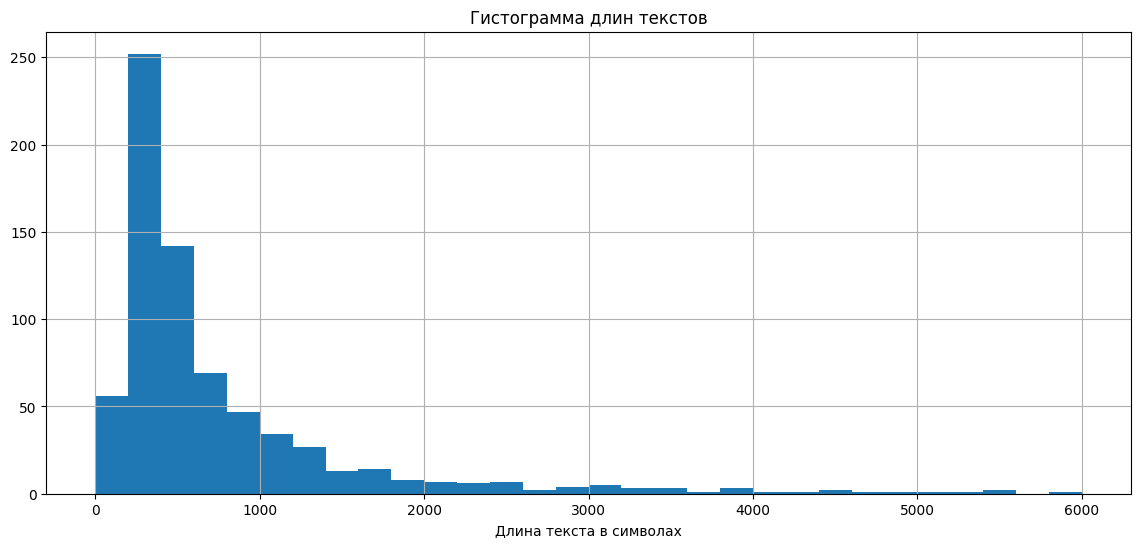

In [14]:
plt.rcParams["figure.figsize"] = (14, 6)
plt.hist(lengths, bins=30, range=[0, 6000])
plt.xlabel("Длина текста в символах")
plt.title("Гистограмма длин текстов")
plt.grid()

In [8]:
lengths = np.array(lengths)
print("Средняя длина", np.mean(lengths))
print("Медиана длины", np.median(lengths))
print("Мода длины", np.bincount(lengths).argmax())

Средняя длина 808.9125
Медиана длины 453.5
Мода длины 221


### Вопрос 1
Где можно будет использовать знание о параметрах распределения длин в выборке?

Выберите длину для генерации

In [15]:
# Устанавливаем, сколько символов будет генерировать модель (максимальная длина генерируемого текста)
MAXLEN = 512 #<your choice here>

# Преобразование данных

Создадим функцию для преобразования текста в вектора одинакового размера для подачи в нейросеть. В этой функции добавляется токен EOS - конец последовательности. Если текст короче заданной длины, то добавляется специальный токен PAD. Если текст больше заданной длины, то он обрезается.

In [16]:
line_ix = [char2id[c] for c in data[5][:512]]

In [17]:
data_ix = np.zeros([len(data[5]), 512], 'int64')
data_ix[5, :len(line_ix)] = line_ix

In [18]:
data_ix= np.transpose(data_ix)
print(data_ix[5])

[0 0 0 ... 0 0 0]


In [19]:
def to_matrix(data, char2id, max_len=None, dtype='int64', batch_first = True):

    max_len = max_len if max_len else max(map(len, data))
    data = [text[:max_len] + " EOS" for text in data]
    data_ix = np.zeros([len(data), max_len], dtype)

    for i in range(len(data)):
        line_ix = [char2id[c] for c in data[i][:max_len]]
        data_ix[i, :len(line_ix)] = line_ix

    if not batch_first: # convert [batch, time] into [time, batch]
        data_ix = np.transpose(data_ix)

    return data_ix

In [20]:
# Проверяем работу функции - кодируем один из текстов и смотрим как он выглядит в кодированном виде
encode = to_matrix(data[:1], char2id, MAXLEN)
print("Исходный текст:\n", data[0])
print("Преобразованный текст:\n", encode[0])

Исходный текст:
 Так и мне узнать случилось,
Что за птица Купидон;
Сердце страстное пленилось;
Признаюсь – и я влюблен!
Пролетело счастья время,
Как, любви не зная бремя,
Я живал да попевал,
Как в театре и на балах,
На гуляньях иль в воксалах
Легким зефиром летал;
Как, смеясь во зло Амуру,
Я писал карикатуру
На любезный женской пол;
Но напрасно я смеялся,
Наконец и сам попался,
Сам, увы! с ума сошел.
Смехи, вольность – всё под лавку
Из Катонов я в отставку,
И теперь я – Селадон!
Миловидной жрицы Тальи
Видел прелести Натальи,
И уж в сердце – Купидон!

Так, Наталья! признаюся,
Я тобою полонен,
В первый раз еще, стыжуся,
В женски прелести влюблен.
Целый день, как ни верчуся
Лишь тобою занят я;
Ночь придет – и лишь тебя
Вижу я в пустом мечтаньи,
Вижу, в легком одеяньи
Будто милая со мной;
Робко, сладостно дыханье,
Белой груди колебанье,
Снег затмивший белизной,
И полуотверсты очи,
Скромный мрак безмолвной ночи —
Дух в восторг приводят мой!..
Я один в беседке с нею,
Вижу… девственну лилею,


### Вопрос 2
Пояснить, что хранится в переменной `encode`.

Как будет выглядеть ваша фамилия в кодированном виде?

# Подготовка нейросети

![](https://raw.githubusercontent.com/tensorflow/text/master/docs/tutorials/images/text_generation_training.png)

Исходя из архитектуры нейросети на картинке, нужно задать 3 слоя:
  - Embedding
  - GRU
  - Dense


Для этого воспользуемся pytorch, ссылки на подробную документацию каждого слоя:
  - [nn.Embedding](https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html)
  - [nn.GRU](https://pytorch.org/docs/stable/generated/torch.nn.GRU.html)
  - [nn.Linear](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html)  

In [22]:
num_embeddings = len(vocab) #количество эмбеддингов должно соответствовать длине словаря
embedding_dim = 32 #определяется размерность эмбеддинга
emb = nn.Embedding(num_embeddings, embedding_dim) # Определяем объект emb как слой эмбеддингов заданного размера

In [34]:

num_embeddings

143

### Вопрос 3
Почему количество эмбеддингов должно соответствовать длине словаря?

В качестве примера пропустим через этот слой первые 5 букв первого текста.

In [23]:
# emb_out - 5 первых символов в виде эмбедингов
emb_out = emb(torch.tensor(encode[0][:5]))
print(f"Размер тензора: {emb_out.shape}\n")
print(emb_out)


Размер тензора: torch.Size([5, 32])

tensor([[ 1.5029e+00, -1.7916e+00,  2.2026e+00, -2.2513e+00, -6.9742e-01,
          3.0790e-01,  6.8104e-01,  7.7460e-01, -6.1624e-01,  1.5153e+00,
         -4.1424e-01, -3.7886e-01,  3.0690e-01,  2.3166e-04, -1.3926e-01,
         -4.1106e-01, -3.6484e-01,  3.3451e-01, -3.3457e+00, -6.2611e-01,
          8.0940e-01,  8.7477e-01, -9.3242e-02,  1.0553e+00,  1.0860e+00,
         -4.8333e-01,  1.1123e+00,  6.2818e-01,  2.5269e-01,  1.3213e+00,
          5.3855e-01,  4.6009e-01],
        [ 5.7508e-01,  1.6589e+00, -1.1679e+00, -2.4309e+00, -3.9557e-01,
          3.8376e-01, -9.8238e-01, -1.1509e+00,  2.2251e+00, -4.6321e-01,
          6.5630e-01, -1.9887e+00, -6.1972e-01, -1.6304e-01, -9.7050e-01,
         -2.5951e-01,  4.9236e-01, -1.9583e+00,  1.9546e+00, -1.0485e+00,
          1.2174e-01,  8.9455e-01, -2.3779e+00,  2.3129e+00, -2.7838e-01,
          9.1432e-01, -2.7290e+00, -1.1626e+00, -8.9565e-01, -8.5091e-03,
          8.8071e-01, -9.9323e-03],
   

### Вопрос 4
Пояснить, почему получен такой размер `emb_out`?

# Создадим ячейку GRU

### Вопрос 5
Обратиться к документации к [nn.GRU](https://pytorch.org/docs/stable/generated/torch.nn.GRU.html) и ответить на вопрос, за что отчечают параметры `input_size`, `hidden_size`, `num_layers`.

В следующей ячейке задать значения для этих параметров

In [25]:
# Определяем ячейку GRU в переменной gru, предварительно задав рамерность скрытого состояния и количество рекуррентных слоев
input_size = emb.embedding_dim # вход в GRU должен соответствовать размеру эмбеддинга
hidden_size = 64 #<your choice here>
num_layers = 1 #<your choice here>
gru = nn.GRU(input_size, hidden_size, num_layers)
output, h_n = gru(emb_out)
print("Размер output:", output.shape)
print("Размер h_n:", h_n.shape)

Размер output: torch.Size([5, 64])
Размер h_n: torch.Size([1, 64])


Выходом GRU является 2 тензора:
  - output (используется для классификации)
  - тензор скрытого состояния h_n (используается для последующей передачи во времени)

Теперь используем output для предсказания следующей буквы, пропустив через линейный слой

In [26]:
in_features = gru.hidden_size
out_features = len(vocab) #предсказываем букву из всего словаря
linear = nn.Linear(in_features, out_features) # Определяем линейный слой. Почему заданы такие входные и выходные параметры для него?
linear_out = linear(output) # output - выход GRU
print("Размер выходного слоя из нейросети: ", linear_out.shape)

Размер выходного слоя из нейросети:  torch.Size([5, 143])


### Вопрос 6
Что содержится в векторе linear_out?

Определить индекс символа, который наиболее вероятно выдаст ячейка GRU на первом шаге?

In [29]:
linear_out[0]

tensor([ 0.0909, -0.0186, -0.2154, -0.2624, -0.0282, -0.1714, -0.0423,  0.1505,
         0.0645,  0.0452, -0.0173, -0.0822,  0.1414,  0.1803, -0.2480, -0.1756,
        -0.0447, -0.0136,  0.1097, -0.2245,  0.0189, -0.0559,  0.0215, -0.0040,
         0.0454,  0.2437, -0.2015,  0.0818,  0.2883,  0.2263, -0.0109,  0.1681,
        -0.0642, -0.0497,  0.1583, -0.0795, -0.0376,  0.0674, -0.1307,  0.0640,
         0.0966,  0.0140, -0.1366, -0.1685,  0.0397, -0.1600, -0.0497, -0.2244,
        -0.1075, -0.1048,  0.0275, -0.0144, -0.1456,  0.0394, -0.1426, -0.0605,
        -0.0743,  0.1303,  0.0337,  0.1010, -0.0651, -0.1233,  0.0282,  0.2729,
         0.0485, -0.0911,  0.1994,  0.0610,  0.0911,  0.0940, -0.0973,  0.0747,
         0.0031,  0.1500, -0.0295,  0.0127, -0.2865, -0.0251, -0.1395,  0.1547,
         0.0830,  0.0782, -0.0181,  0.1317, -0.0537,  0.1293, -0.2458,  0.1477,
        -0.0610, -0.0592, -0.2878, -0.1622,  0.1336,  0.0987, -0.0834, -0.0815,
        -0.1764,  0.0202, -0.0097,  0.01

Теперь определим класс со всеми частями:

In [30]:
class CharGRULoop(nn.Module): # Описываем инициализатор класса.
    def __init__(self, num_embeddings=52, embedding_dim=16, hidden_size=64, num_layers=1): # В методе __init__ определим архитектуру модели, создав необходимые слои
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(num_embeddings, embedding_dim)
        self.gru = nn.GRU(embedding_dim, hidden_size, num_layers, batch_first=True)
        self.hid_to_logits = nn.Linear(hidden_size, num_embeddings)

    def forward(self, x, hid_state): # Здесь описываем стурктуру сети - как сигнал должен по ней проходить
        x = self.emb(x) # Проходим через эмбеддинг-слой
        if hid_state is not None: # Проходим через GRU, сохраняя hidden state
            h_seq, hid_state = self.gru(x, hid_state)
        else:
            h_seq, hid_state = self.gru(x)
        next_logits = self.hid_to_logits(h_seq) # проходим через полносвязный слой
        next_logp = F.log_softmax(next_logits, dim=-1) # Используем функцию softmax
        return next_logp, hid_state

Определим модель:

In [35]:
model = CharGRULoop(num_embeddings=len(vocab), embedding_dim=64, hidden_size=192, num_layers=2)
#<your choice here> Можно попробовать создать сеть с другими значениями параметров

Количество  параметров:

In [32]:
!pip -q install torchinfo

In [36]:
from torchinfo import summary

summary(model)

Layer (type:depth-idx)                   Param #
CharGRULoop                              --
├─Embedding: 1-1                         9,152
├─GRU: 1-2                               370,944
├─Linear: 1-3                            27,599
Total params: 407,695
Trainable params: 407,695
Non-trainable params: 0

Каждый раз, когда вы вызываете модель (forward), вы передаете некоторый текст и внутреннее состояние. Модель возвращает прогноз для следующего символа и его нового состояния.

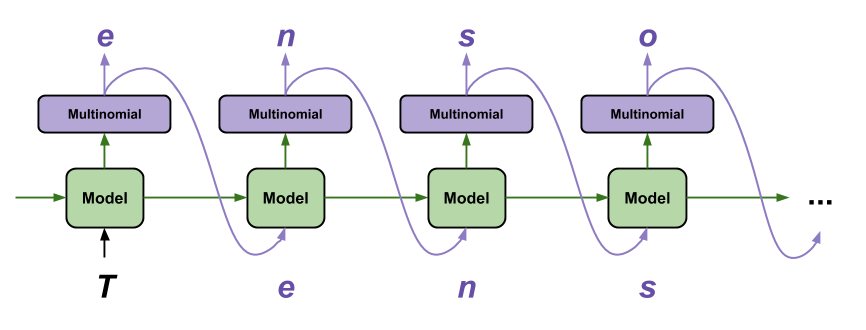

Функция для генерации последовательности символов (текста)

In [39]:
def generate_sample(model, char2id, id2char, seed_phrase=' ', strategy="greedy", max_length=100, temperature=1.0):
    """
      model - нейросеть
      char2id - словарь преобразования букв в их индексы
      id2char - словарь преобразования индексов в буквы
      seed_phrase - начальная фраза для генерации
      strategy - стратегия генерации (жадная "greedy" или сэмплирование "sample")
      max_length - максимальная длина сгенирированного текста
      temperature - ???
    """

    x_sequence = [char2id[token] for token in seed_phrase] # кодируем начальную фразу
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64) # создаем тензор
    hid_state = None # задаем тензор скрытого состояния h_n, при такой подачи вектор заполнится нулями

    with torch.no_grad(): # отключаем подсчет градиентов, поскольку сеть уже обучена и не нужно проводить обратное распространение ошибки
      for i in range(len(seed_phrase) - 1): # подаем номер буквы и hid_state в цикле
          _, hid_state = model(x_sequence[:, i].unsqueeze(0), hid_state)

      # начинаем генерацию
      for _ in range(max_length - len(seed_phrase)):

          logp_next, hid_state = model(x_sequence[:, -1].unsqueeze(0), hid_state) # подаем последнюю букву из фразы
          p_next = F.softmax(logp_next / temperature, dim=-1).data.numpy()[0] # нормируем выходы модели на температуру и применяем софтмакс

          if strategy == "greedy": next_ix = p_next.argmax() #берем токен с максимальной вероятностью
          elif strategy == "sample": next_ix = np.random.choice(len(id2char), p=p_next[0]) #получаем следующий токен сэмплированием с вероятностями
          else: raise ValueError('Хулиган, не делай так! Выбери "greedy" или "sample"')

          if id2char[next_ix] == "EOS": break # если получили токен EOS, то прекращаем генерацию
          else:
            next_ix = torch.tensor([[next_ix]], dtype=torch.int64) # создаем тензор следующий буквы
            x_sequence = torch.cat([x_sequence, next_ix], dim=1) # добавляем предсказанный токен в конец последовательности

    return ''.join([id2char[ix] for ix in x_sequence.data.numpy()[0]]) # возвращаем декодированную строку

Попробуем что-нибудь сгенерировать:

### Вопрос 7
Выполните следующую ячейку несколько раз с одной и той же SEED_PHRASE, запомните выводы модели и объясните результат - чем отличается стратегия greedy от sample?

In [43]:
SEED_PHRASE = 'Я люблю машинное обучение!\n' # Ну или что-то другое
print(generate_sample(model, char2id, id2char, seed_phrase=SEED_PHRASE, strategy="greedy", max_length=100))
print()
print(generate_sample(model, char2id, id2char, seed_phrase=SEED_PHRASE, strategy="sample", max_length=100))



Я люблю машинное обучение!
ддZгàuгuuZsàCCCCОааа___IIшCCОаа!___IICйCCОаа!___IICйCCОаа!___IICйCCОаа!__

Я люблю машинное обучение!
<eâSайб«.<К»èôOг:cq<ыэôuqьW!Пто'ryS«щаâЖmХàrûЯзVЛОZhJripиDUhLСасм…шп-ЙpCà


Разделим данные на тренировачные и тестовые, подготовим Dataloader для подачи в нейросеть

In [44]:
from sklearn.model_selection import train_test_split

batch = 128 # Тексты, для уменьшения накладных расходов, будем подавать на вход модели "батчами" - блоками по 128 документов

train, test = train_test_split(data, test_size=0.2, random_state=42, shuffle=True)

dataset_train = TensorDataset(torch.tensor(to_matrix(train, char2id, max_len=MAXLEN)))
dataloader_train = DataLoader(dataset_train, batch_size=batch, shuffle=True)

dataset_test = TensorDataset(torch.tensor(to_matrix(test, char2id, max_len=MAXLEN)))
dataloader_test = DataLoader(dataset_test, batch_size=batch, shuffle=False)

Переопределим модель, зададим оптимизатор, лосс-функцию

In [50]:
model = CharGRULoop(num_embeddings=len(vocab), embedding_dim=64, hidden_size=256, num_layers=3)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.NLLLoss(ignore_index=char2id["PAD"])
# Функция потерь - negative log likelihood loss (NLL Loss) - используеся для задачи многоклассовой классификации в ситуации, когда имеются логарифмы вероятностей каждого класса
# NLL Loss эквивалентен CrossEntropyLoss, но применяется к логарифмам вероятностей - у нас на выходе линейного слоя как раз исопользуется функция softmax

summary(model)

Layer (type:depth-idx)                   Param #
CharGRULoop                              --
├─Embedding: 1-1                         9,152
├─GRU: 1-2                               1,036,800
├─Linear: 1-3                            36,751
Total params: 1,082,703
Trainable params: 1,082,703
Non-trainable params: 0

Необученная модель не может делать адекватные предсказания. Ее перплексия («коэффициент неопределённости») приблизительно равна размеру словаря. Это говорит о полной неопределенности модели при генерации текста.

In [46]:
train[:1]

['Буря мглою небо кроет,\nВихри снежные крутя:\nТо, как зверь, она завоет,\nТо заплачет, как дитя,\nТо по кровле обветшалой\nВдруг соломой зашумит,\nТо, как путник запоздалый,\nК нам в окошко застучит.\n\nНаша ветхая лачужка\nИ печальна, и темна.\nЧто же ты, моя старушка,\nПриумолкла у окна?\nИли бури завываньем\nТы, мой друг, утомлена,\nИли дремлешь под жужжаньем\nСвоего веретена?\n\nВыпьем, добрая подружка\nБедной юности моей,\nВыпьем с горя; где же кружка?\nСердцу будет веселей.\nСпой мне песню, как синица\nТихо за морем жила;\nСпой мне песню, как девица\nЗа водой поутру шла.\n\nБуря мглою небо кроет,\nВихри снежные крутя;\nТо, как зверь, она завоет.\nТо заплачет, как дитя.\nВыпьем, добрая подружка\nБедной юности моей,\nВыпьем с горя; где же кружка?\nСердцу будет веселей.\n\n']

In [47]:
example = torch.tensor(to_matrix(train[:1], char2id, max_len=MAXLEN)) # Возьмем первый документ и попробуем сгененировать этот же текст начиная с первой буквы

train_example = example[:, :-1]
target_example = example[:, 1:]

next_logp, hid_state = model(train_example, hid_state=None)

print('perplexity: ', torch.exp(loss_fn(next_logp.permute(0, 2, 1), target_example)).item())

perplexity:  141.7220001220703


In [48]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
torch.cuda.empty_cache()

Обучение. Эта ячейка займет 5-8 минут

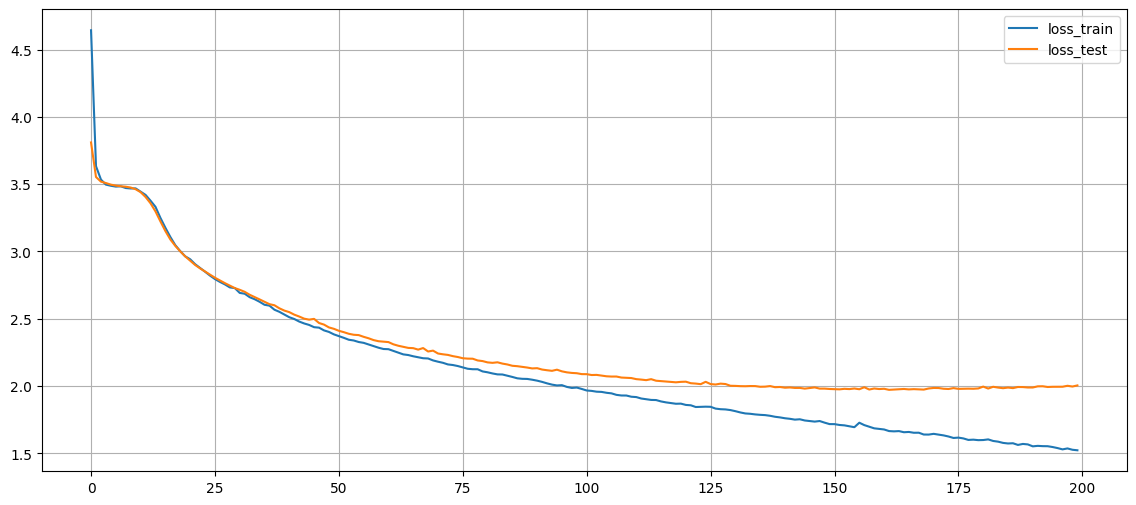

In [49]:
EPOCH = 200 # количество эпох обучения
history_train = [] # список значений лосса трейна на каждой эпохи
history_test = [] # список значений лосса теста на каждой эпохи
model.to(device) # И модель, и данные должны находиться на одном устройстве.
                 # Поэтому при работе с GPU нужно следить и явно указывать, на каком устройстве проводится работа.


best_test_loss = float("inf")
for i in range(EPOCH): #цикл по эпохам

  loss_test = 0
  loss_train = 0

  for batch in dataloader_train: #цикл по тренировачным батчам

    optimizer.zero_grad() #обнуляем градиенты
    batch_ix = torch.tensor(batch[0], dtype=torch.int64).to(device) #делаем из батча тензор

    predictions_logp, _ = model(batch_ix[:, :-1], hid_state=None) #подаем батч в модель

    actual_next_tokens = batch_ix[:, 1:] # таргеры

    loss = loss_fn(predictions_logp.permute(0, 2, 1), actual_next_tokens.long()) # считаем лосс на батче
    loss_train += loss.item() # добавляем лосс с батча в суммарный лосс

    loss.backward() # делаем обратный проход
    optimizer.step() # делаем шаг оптимизатором

  history_train.append(loss_train/len(dataloader_train)) # добавляем  средний лосс за эпоху в список

  for batch in dataloader_test: #цикл по тестовым батчам
    with torch.no_grad(): # отключаем подсчет градиентов

      batch_ix = torch.tensor(batch[0], dtype=torch.int64).to(device)
      predictions_logp, _ = model(batch_ix[:, :-1], hid_state=None)

      actual_next_tokens = batch_ix[:, 1:]

      loss = loss_fn(predictions_logp.permute(0, 2, 1), actual_next_tokens.long())
      loss_test += loss.item()

  loss_test = loss_test/len(dataloader_test)
  history_test.append(loss_test)

  if loss_test < best_test_loss: #сохраняем лучшую модель по лоссу на тесте
    best_test_loss = loss_test
    best_model = copy.deepcopy(model)
    best_model.to("cpu")

  if (i + 1) % 5 == 0: # выводим график лосса каждые 5 эпох
    clear_output(True)
    plt.plot(history_train, label='loss_train')
    plt.plot(history_test, label='loss_test')
    plt.grid()
    plt.legend()
    plt.show()


### Вопрос 8
Достаточно ли обучилась модель? Имеет ли смысл изменить количество эпох обучения?

In [51]:
print("perplexity (best model test): ", np.exp(best_test_loss))
print("perplexity (last epoch test): ", np.exp(loss_test))

perplexity (best model test):  7.181648032772434
perplexity (last epoch test):  7.421088521940808


In [52]:
device = 'cpu' # Обучение обычно проводится на GPU, но чтобы не тратить его ресурсы, работу по генерации текста уже обученной моделью стоит перенести обратно на CPU
model.to(device)

CharGRULoop(
  (emb): Embedding(143, 64)
  (gru): GRU(64, 256, num_layers=3, batch_first=True)
  (hid_to_logits): Linear(in_features=256, out_features=143, bias=True)
)

Погенерируем текст. Сначала зададим стартовую фразу.

Выполнив следующие ячейки по несколько раз, убедитесь, что правильно ответили на вопрос 7 "Чем отличается стратегия greedy от sample?"

In [53]:
#Если вы не согласны, вы можете поменять стартовую фразу, но что думает об этом высказывание машина?
SEED_PHRASE = 'Теория автоматического управления - лучший предмет,'

Sample strategy

In [56]:
print(generate_sample(best_model, char2id, id2char, seed_phrase=SEED_PHRASE, strategy="sample", max_length=MAXLEN))

Теория автоматического управления - лучший предмет,
В вечерчят, может и ребких ряд,
Когда в тихает Наздним не рафстились взор,
Где боющей слус во знали цвю,
Еврожачи в пустыню твоей, прочей,
В Ажертрянный лес пропариду улещенье,
Истревняешь литее молви от меня за Eилей
В и ждох эти пыраматься спомнорой,
И вишел ее пеельчим на пытом.

Зевители, моей пужко образ роды погоглавляек;
Скворный, сокружлен ускоре вином:

 EOS любится каз ним меня дороды!
Всях казы-тро ты сладо мною рошу.
Нет, и красота тебе прироща


In [ ]:
#prompt = "<не сдерживайте себя, сгенерируйте что-нибудь про соседа>"
#print(generate_sample(model, char2id, id2char, seed_phrase=prompt, strategy="sample", max_length=256))

Greedy strategy:


In [58]:
print(generate_sample(best_model, char2id, id2char, seed_phrase=SEED_PHRASE, strategy="greedy", max_length=MAXLEN))

Теория автоматического управления - лучший предмет,
И в тебе под него не след не внемлет он мой под сон,
И в тебя с полей под сенью покой приветный страсть устались,
И в тебя в тебя с поле под сенью покой,
И с тобой страсть и страсть у него в поле молчаливой,
И с тобой в тебе с полей под страсть и страсть на волненье,
И в тебя в тебя с поле под страсть и страсть на восторга,
И с тебя с невольно прости страсть и страсть на восторга,
И с тебя с невольно прости страсть и страсть на восторга,
И с тебя с невольн


In [59]:
#prompt = "<не сдерживайте себя, сгенерируйте что-нибудь про соседа>"
#print(generate_sample(model, char2id, id2char, seed_phrase=prompt, strategy="sample", max_length=256))

# Эксперименты с температурой

В функции `generate_sample` есть параметр `temperature`.

Основываясь на прошлом пункте, выберите стратегию, которая больше понравилась и запустите ячейки с разной температурой

In [60]:
nice_strategy = "sample" #<your choice here>

In [61]:
print(generate_sample(best_model, char2id, id2char, seed_phrase=SEED_PHRASE, strategy=nice_strategy, max_length=MAXLEN, temperature=2.0))

Теория автоматического управления - лучший предмет,
Нет.У дух преБЦя! убиием?> Скутxщ:: —
мбебле) был за цев чещу
Па. ТДа чевтовых: а домите,
Хтон живлчивые Посов, я , куке, лесь,
<пучалу> лябесимlим КлOE<жуе оRлки-пом,
Бедпятные пъе! сrакиса: ебя.
. нелаться, лены яхтну…
М зигранном дня, <судую,
Афием, П*";c——
ДТрома, нуй, чтоко и; Дьбл
Еу! укнавнпиdусем.и.. ь,я

Гдю Увер!ы
Дррикаявь, твое гофJ —!
Уе.ш. И, Бстоъ тиханью,
Лю??
Хласуя âлучит хожделz штон!…Л.
…»>
ожестгу<чиг
Ясь.…а хванни дупгухНвеннемляцы. —


### Вопрос 9
Сделайте выводы как влияет изменение температуры на генерацию текста.

Выберите оптимальное значение температуры

In [63]:
# По завершению работы с рекуррентной сетью, очистим кэш
torch.cuda.empty_cache()

# Bonus track GPT

Дальше происходит магия, чтобы все вышло:
  - здесь лучше перезапустить сеанс (Среда выполнения -> Перезапустить сеанс

In [1]:
!pip install -q transformers[torch]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.3/297.3 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 43.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 46.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 62.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━

In [23]:
import locale
import torch
import transformers
import numpy as np

from warnings import simplefilter
from IPython.display import clear_output
from transformers import Trainer, TrainingArguments
from transformers import GPT2LMHeadModel, GPT2Tokenizer
from transformers import TextDataset, DataCollatorForLanguageModeling


In [3]:
#  Задаем некоторые настроечные параметры касательно кодировки и отображения предупреждений
locale.getpreferredencoding = lambda: "UTF-8"
simplefilter("ignore", category=FutureWarning)
transformers.logging.set_verbosity_error()

In [4]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_name = "sberbank-ai/rugpt3small_based_on_gpt2"  # Опередлим, какой моделью будем пользоваться
tokenizer = GPT2Tokenizer.from_pretrained(model_name)  # Определим токенайзер для нашего текста
model = GPT2LMHeadModel.from_pretrained(model_name).to(device) # Загрузим предобученную модель трансформера rugpt3small от Сбера

clear_output()

In [7]:
SEED_PHRASE = 'Теория автоматического управления - лучший предмет,'
input_ids = tokenizer.encode(SEED_PHRASE, return_tensors="pt").to(device)
out = model.generate(input_ids, do_sample=False, max_length=20)

generated_text = list(map(tokenizer.decode, out))[0]

print(generated_text) #Так работает предобученный трансформер

Теория автоматического управления - лучший предмет, который я знаю.









Давайте дообучим трансформер на нашем датасете - мы хотим генерировать стихи

In [17]:
train_path = "train_dataset.txt"

with open("poems.txt", encoding="utf-8") as file:
  data = file.read().split("</s>\n\n")

with open(train_path, mode="w", encoding="utf-8") as f:
    f.write("".join(data))

In [18]:
train_dataset = TextDataset(tokenizer=tokenizer, file_path=train_path, block_size=128) # Создание датасета
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False) # Создание даталодера (нарезает текст на оптимальные по длине куски)

In [19]:

training_args = TrainingArguments(
    output_dir="./finetuned",
    overwrite_output_dir=True,
    num_train_epochs=15,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    warmup_steps=10,                    # рекомендованные значения (warmup_steps нужен для "разогрева" сети, c его помощью learning rate постепенно увеличивается до заданного значения)
    gradient_accumulation_steps=16,     # рекомендованные значения
)
#(обычно мы хотим положить батч по-больше, чтобы сеть побыстрей сошлась, но мы ограничены памятью gpu, gradient_accumulation_steps накапливает (суммирует или усредняет) градиенты за прогон на 16 батчах )

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset,
    optimizers=(
        torch.optim.AdamW(model.parameters(), lr=1e-5), # рекомендованные значения
        None,
    ),
)

# Эта ячейка займет около 15-20 минут

<span style="color:red">Добавил тут переменную, откуда потом берется лосс с трейна и считается перплексия</span>.

In [20]:
output = trainer.train() # Дообучаем трансформер на наши тексты

{'train_runtime': 512.7748, 'train_samples_per_second': 43.499, 'train_steps_per_second': 0.059, 'train_loss': 4.064910634358724, 'epoch': 10.21}


In [21]:
print('perplexity: ', np.exp(output.training_loss)) #расчет перплексии

perplexity:  58.25970187428917


### Вопрос 10
Какое значение перплексии получилось у трансформера?

Какое значение перплексии получалось у рекуррентной сети?

Почему у рекуррентной сети значение было существенно ниже, но качество текстов хуже? Почему нельзя сравнивать значения для рекуррентной сети и трансформера?


In [22]:
SEED_PHRASE = 'Теория автоматического управления - лучший предмет,'
input_ids = tokenizer.encode(SEED_PHRASE, return_tensors="pt").to(device)
model.eval()
with torch.no_grad():
    out = model.generate(
        input_ids,
        do_sample=True, # sample strategy
        temperature=1.0,
        max_length=256,
        pad_token_id=512 # указываем id <PAD> токена
    )

generated_text = list(map(tokenizer.decode, out))[0]
print()
print(generated_text)


Теория автоматического управления - лучший предмет,
Когда в нем все подчинено закону. 

И только законы в нем
Ошибки и воры
Так искусно ведут против
Нимфы его дела;
Они как раз в ней с самого начала
Узрели: человек есть душа,
Коли вдруг он не становится ни грешным,
Ни преступником,
Ни преступником.

Он как будто в ней живет,
И в ней дух живет,
В ней свет есть для всех он,
Она его питает,
Она о нем поет.

Но для него ничего не значит
Свой день, свои жертвы,
Он не может быть свободен,
И он ни над кем не властен:
В нем весь ход земного рая
В нем его предел.

Он хочет жить, он хочет умереть,
Готов он ко всему и не может
Предать себя сомненьем;
В нем человек в конце концов
Перестает жить и для себя.
Ведь он же человек,
Он ведь даже в своем законе
Омертвляет грех силою мысли.

Но все напрасно: с нею человек живет:
И в нем живет она со своей душой.
Но


### Вопрос 11
Проверьте работу ячейки выше для разных стартовых фраз и разных параметров `temperature`, `max_length`, `do_sample` и объясните, за что отвечает каждый из параметров. Подберите (субъективно) лучшие

# Beam Search
До этого мы использовали обычный "жадный" поиск

![](https://huggingface.co/blog/assets/02_how-to-generate/greedy_search.png)

Для каждого слова следующим считали _наиболее вероятное_.
Но, возможно, пройдя по не самому вероятному слову, в итоге мы получим более вероятную __последовательность__ слов, чем при жадном алгоритме.
Такой подход называется Beam search.

![](https://huggingface.co/blog/assets/02_how-to-generate/beam_search.png)

[подробнее тут](https://huggingface.co/blog/how-to-generate)

Для использования Beam search передадим в функцию генерации параметр `num_beams` который характеризует количество рассматриваемых "альтернативных" путей

In [105]:
SEED_PHRASE = 'Теория автоматического управления - лучший предмет,'
input_ids = tokenizer.encode(SEED_PHRASE, return_tensors="pt").to(device)
model.eval()
with torch.no_grad():
    out = model.generate(
        input_ids,
        do_sample=False,
        max_new_tokens=75,
        no_repeat_ngram_size=3, # устанавливает вероятность 0 для повторяющихся n-gram (таким образом решается проблема зацикливания)
        pad_token_id=512,
        num_beams=5,
        num_return_sequences=5,  # количество возвращенных сгенерированных текстов отранжированных по вероятности после beam_search
        top_p=0.9, #<your choice here>
        top_k=20, #<your choice here>
        temperature=2.0 #<your choice here>
    )

generated_text = list(map(tokenizer.decode, out))


In [106]:
# Выведем _num_return_sequences_ сгенерированных текстов
for i, seq in enumerate(generated_text):
  print(f"Applicant {i}", seq, "\n", sep="\n")

Applicant 0
Теория автоматического управления - лучший предмет,
Который я когда-либо читал.

Я знаю, что это не так,
Но я не знаю, как это объяснить.
Я не знаю даже, как объяснить
То, что я знаю, и то, что не знаю.
И я знаю только то,
Что знаю я, но не знаю
И того, и другого.



Applicant 1
Теория автоматического управления - лучший предмет,
Который я когда-либо читал.

Я знаю, что это не так,
Но я не знаю, как это объяснить.
Я не знаю даже, как объяснить
То, что я знаю, и то, что не знаю.
И я знаю только то,
Что знаю я, но не знаю
И того, что знаю я.


Applicant 2
Теория автоматического управления - лучший предмет,
Который я когда-либо читал.

Я знаю, что это не так,
Но я не знаю, как это объяснить.
Я не знаю даже, как объяснить
То, что я знаю, и то, что не знаю.
И я знаю только то,
Что знаю я, но не знаю
И то, и другое.



Applicant 3
Теория автоматического управления - лучший предмет,
Который я когда-либо читал.

Я знаю, что это не так,
Но я не знаю, как это объяснить.
Я не знаю даж

 Дополнительно можно изучить смысл параметров top_p и top_k [по ссылке](https://huggingface.co/blog/how-to-generate)

Опробуйте разные значения параметров, какая схема выборки получилась лучше?

Сохранить модель при необходимости:

In [ ]:
#torch.save(model, "gpt2_finetune.torch")
#mod = torch.load("gpt2_finetune.torch")

### Вопрос 12
Вместо вывода добавьте лучший сгенерированый текст за лабораторную работу и напишите при какой архитектуре и при каких параметрах он получен:

Например:  tuned gpt3 with params:

* do_sample=True,
* max_new_tokens=80,
* no_repeat_ngram_size=3,
* ...


В мире, где порядок стремится к хаосу,

Теория управления - свет во тьме.

Автоматы, системы, в них неспроста

Скрыт закон, управляющий временем.


Регуляторы, обратные связи,

В этом мире - как волшебный ключ.

С их помощью мы можем, без отказа,

Двигать системы, чьё движенье - дым.



В каждом узле, в каждом переходе

Скрыта струна, что звучит на удивление чисто.

ТАУ нас учит, как в море перемен,

Найти путь, где устойчивость - не миф, а быль.

# Контрольные вопросы
1. В чем особенность рекуррентных нейронных сетей?
1. Типы рекуррентных сетей - обычная RNN
1. Типы рекуррентных сетей - LSTM
1. Типы рекуррентных сетей - GRU
1. Что такое и как вычисляется перплексия
1. Что такое "предобученная" модель и для чего ее нужно "дообучать"?
